In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [2]:
df = pd.read_excel('./Datasets/TimeSeries/Superstore.xls')
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
Row ID           2121 non-null int64
Order ID         2121 non-null object
Order Date       2121 non-null datetime64[ns]
Ship Date        2121 non-null datetime64[ns]
Ship Mode        2121 non-null object
Customer ID      2121 non-null object
Customer Name    2121 non-null object
Segment          2121 non-null object
Country          2121 non-null object
City             2121 non-null object
State            2121 non-null object
Postal Code      2121 non-null int64
Region           2121 non-null object
Product ID       2121 non-null object
Category         2121 non-null object
Sub-Category     2121 non-null object
Product Name     2121 non-null object
Sales            2121 non-null float64
Quantity         2121 non-null int64
Discount         2121 non-null float64
Profit           2121 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(13)
memory usage: 364.5

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

We have a good 4-year furniture sales data.

## Data Preprocessing

In [5]:
furniture.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit']

furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values(by='Order Date')

## Check for missing Values
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with Time Series Data

In [9]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [10]:
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [11]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 furniture sales data.

In [12]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing Furniture Sales Time Series Data

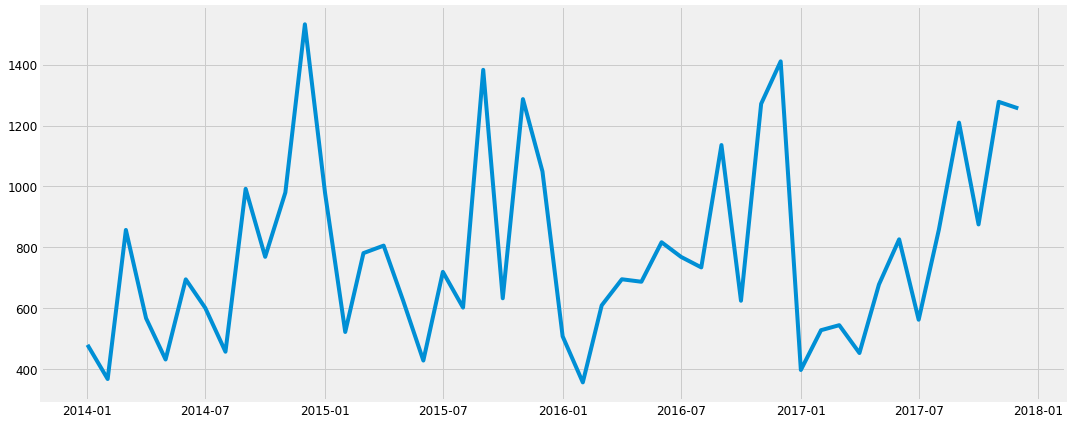

In [13]:
plt.figure(figsize=(15,6))
plt.plot(y)
plt.tight_layout()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

In [45]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

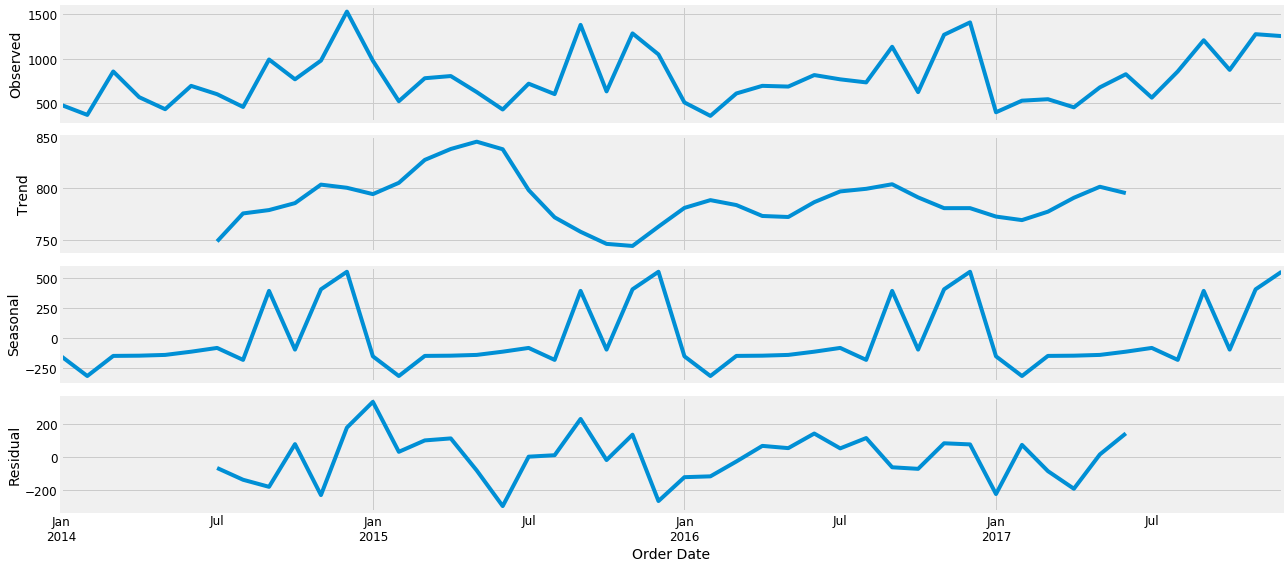

In [46]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [21]:
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.SARIMAX(y, order=param, seasonal_order=seasonal_param)
            results = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


We should always run model diagnostics to investigate any unusual behavior.

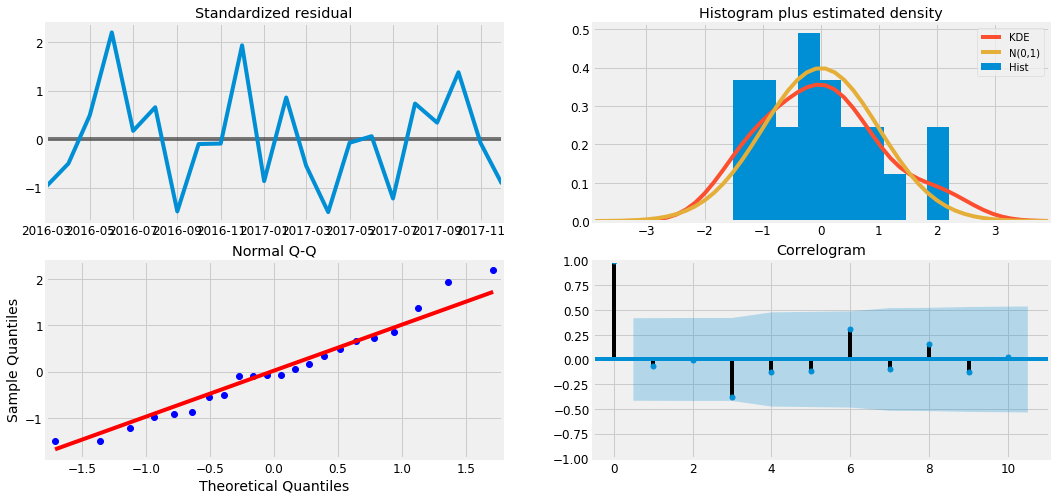

In [23]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

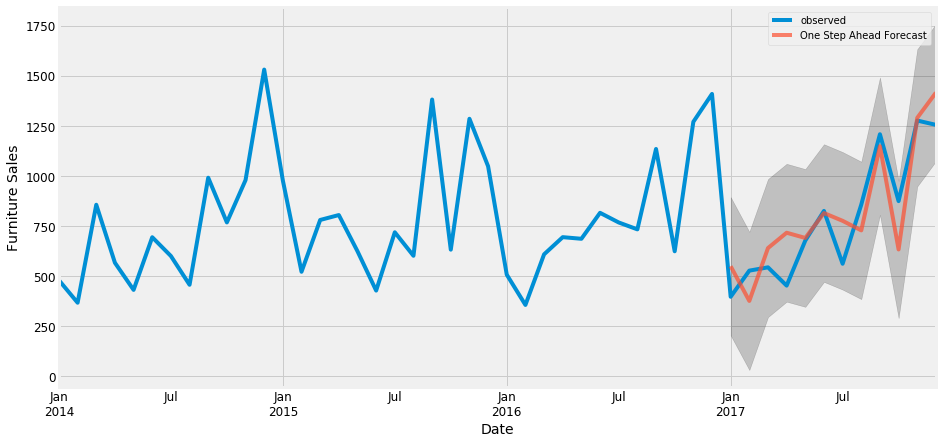

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One Step Ahead Forecast', alpha=0.7, figsize=(14,7))

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [28]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.58


In [29]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


## Producing and visualizing forecasts

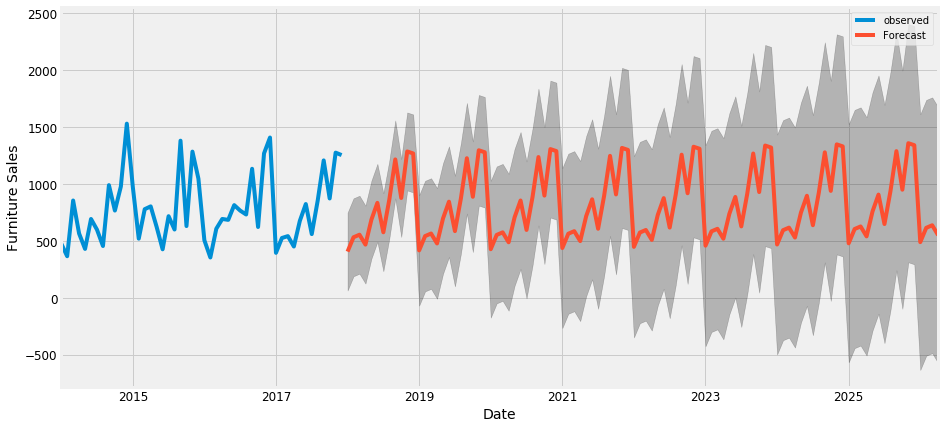

In [30]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()